# Hello California Housing Prices Regressor

End to end Regressor model for California Housing Prices dataset utilizing scikit-learn

In [1]:
# Prerequisites
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
print("Python Version: ", sys.version)
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
np.set_printoptions(precision=3, suppress=True)

Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Numpy Version:  2.2.2
Pandas Version:  2.2.3


### Fetch and load the dataset

In [2]:
# Prerequisites
from pathlib import Path
import urllib.request
import tarfile

In [3]:
def fetch_housing_dataset():
    tarball_path = Path("datasets/housing.tgz")
    # If file does not exist, fetch it from the net
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_data_file:
            housing_data_file.extractall(path="datasets")

    return pd.read_csv(Path("datasets/housing/housing.csv"))
    

df_housing_raw = fetch_housing_dataset()
df_housing_raw.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Exploratory Data Analysis

In [4]:
df_housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


All numberical features, except ocean_proximity.  Examine the values and distribution of Ocean_proximity

In [5]:
df_housing_raw["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
df_housing_raw.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Visualize Histogram

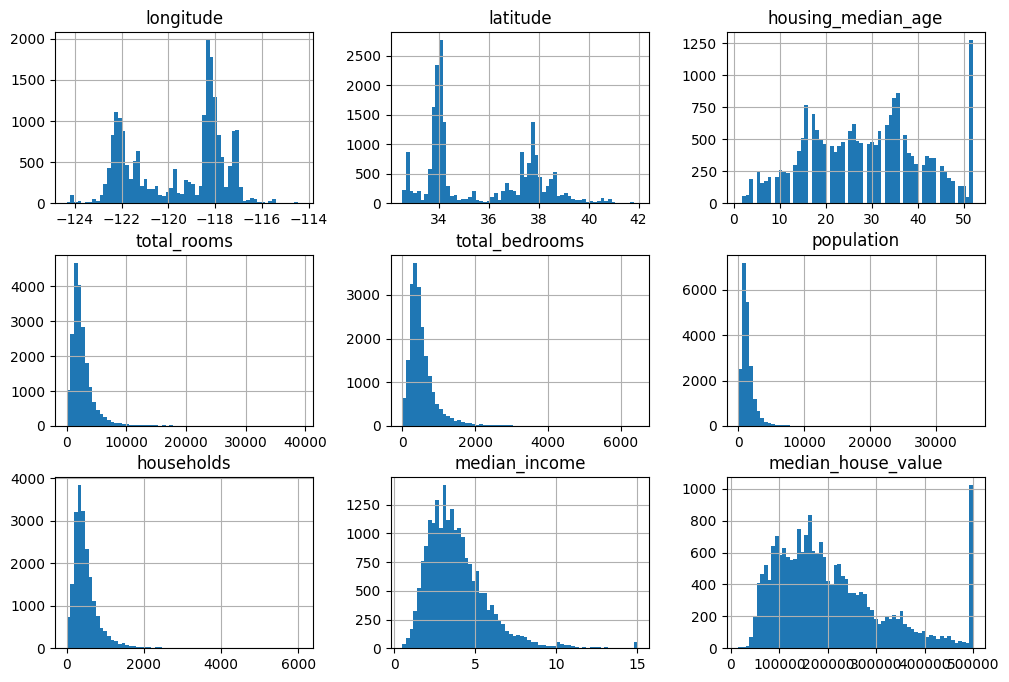

In [7]:
df_housing_raw.hist(bins=64, figsize=(12,8))
plt.show()

### Split into Train and Test sets

Random Split

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_housing_raw, train_size=0.8, random_state=42)

print(f"Training set size: {df_train.shape[0]}, Test set size: {df_test.shape[0]}")

Training set size: 16512, Test set size: 4128


Ensure that median_income categories get proper representation in the test set

In [9]:
# Split median_income into categories:
df_housing_raw["income_cat"] = pd.cut(df_housing_raw["median_income"],
                                      bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                      labels=[1,2,3,4,5])

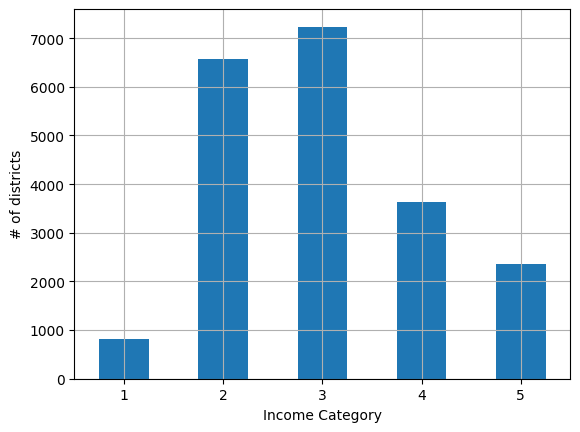

In [10]:
# Visualize the categories
df_housing_raw["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("# of districts")
plt.show()

Perform a Stratified Shuffle Split

In [11]:
df_train_strat, df_test_strat = train_test_split(df_housing_raw, train_size=0.8, 
                                                 stratify=df_housing_raw["income_cat"],
                                                 random_state=42)

print(f"Stratified Training set size: {df_train_strat.shape[0]}, Test set size: {df_test_strat.shape[0]}")

Stratified Training set size: 16512, Test set size: 4128


In [12]:
# Drop income_cat column, no longer needed

for df in (df_train_strat, df_test_strat):
    df.drop("income_cat", axis=1, inplace=True)

### Visualize Geographical Data

Make a copy of the training dataset for further exploration

In [13]:
df_housing = df_train_strat.copy()

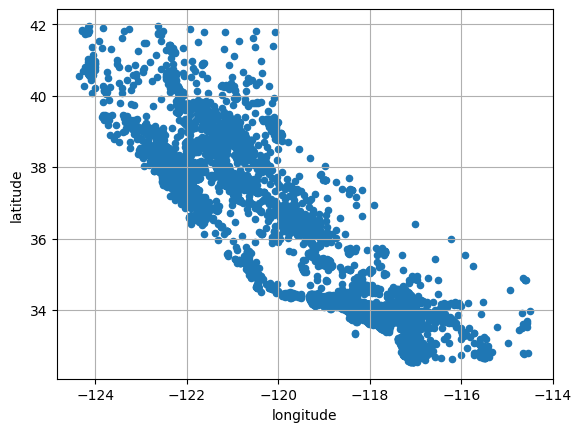

In [14]:
df_housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

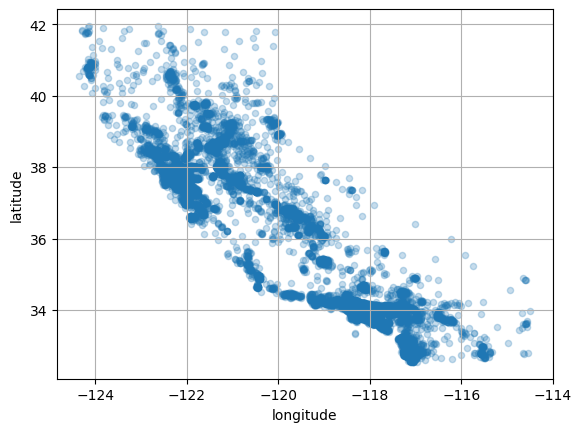

In [15]:
# Look for high density areas
df_housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.25)
plt.show()

#### Add Visualization of Population & Housing Prices

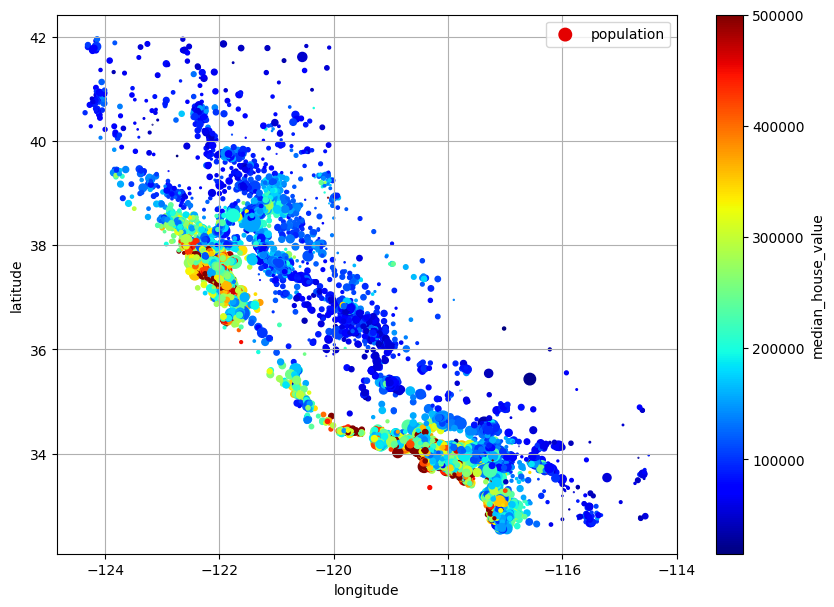

In [16]:
# Visualize population with circle size and housing prices with color
df_housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
                s=df_housing["population"]/100, label="population",
                c="median_house_value", cmap="jet", colorbar=True,
                legend=True, sharex=False, figsize=(10,7))
plt.show()

### Calculate Pearson's Correlation Coefficient between features

In [17]:
correlation_matrix = df_housing.corr(numeric_only=True)
correlation_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Plot scatter plots between some features that likely highly correlated

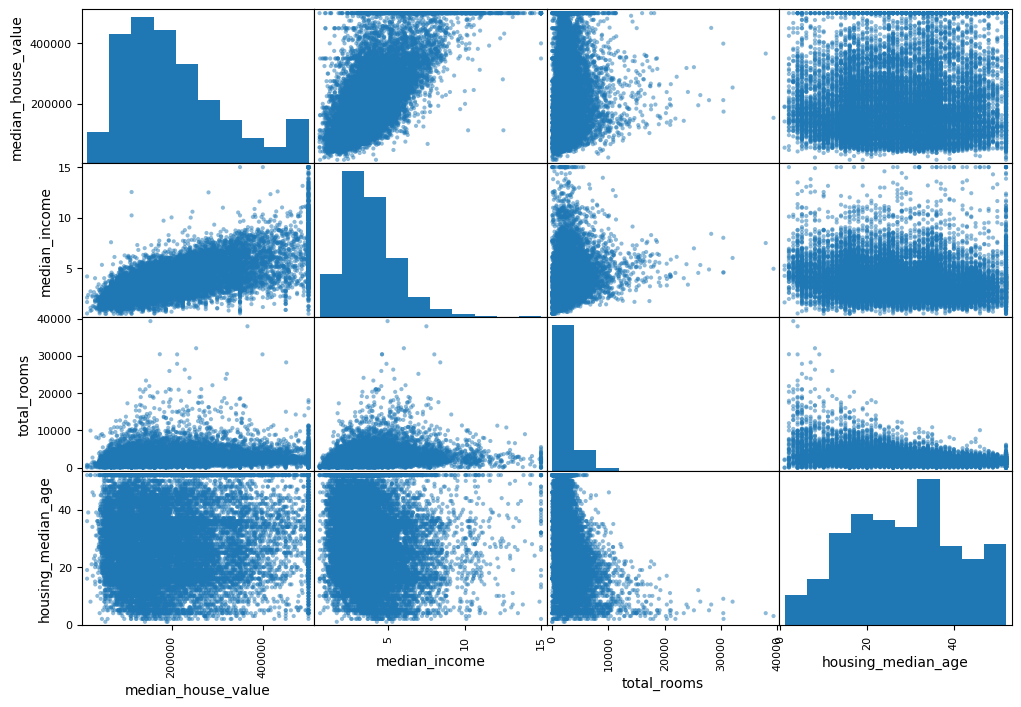

In [18]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

pd.plotting.scatter_matrix(df_housing[attributes], figsize=(12,8))
plt.show()

Look at Median Income vs. Median House Price in more detail

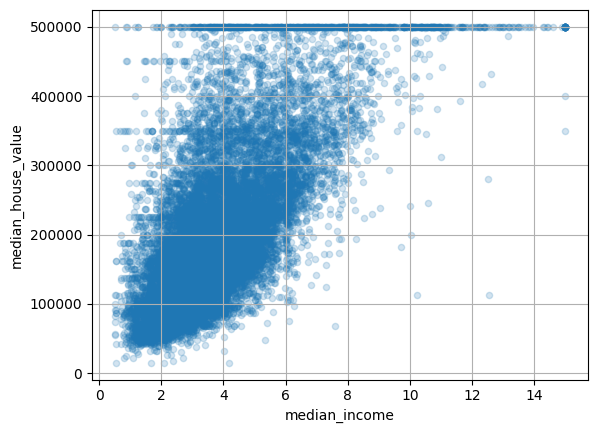

In [19]:
df_housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2, grid=True)
plt.show()

#### Check if there are better Attribute Combinations

In [20]:
df_housing["rooms_per_house"] = df_housing["total_rooms"] / df_housing["households"]
df_housing["bedrooms_ratio"] = df_housing["total_bedrooms"] / df_housing["total_rooms"]
df_housing["people_per_house"] = df_housing["population"] / df_housing["households"]

# Re-look correlations
correlation_matrix = df_housing.corr(numeric_only=True)
correlation_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

### Data Cleaning

Start from the saved train set and remove the target values

In [21]:
df_housing = df_train_strat.drop("median_house_value", axis=1)
df_housing_labels = df_train_strat["median_house_value"].copy()

In [22]:
df_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN


In [23]:
df_housing_labels.head()

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
Name: median_house_value, dtype: float64

"total_bedrooms" had missing values, possible stategies to deal with the missing values with Pandas:
```python
housing.dropna(subset=["total_bedrooms"], inplace=True)    # option A

housing.drop("total_bedrooms", axis=1)       # option B

median = housing["total_bedrooms"].median()  # option C
housing["total_bedrooms"].fillna(median, inplace=True)
```

For simplicity, use scikit-learn Imputer

In [24]:
from sklearn.impute import SimpleImputer

simple_imputer = SimpleImputer(strategy="median")

In [25]:
# Separate numerica features, as imputer cannot be used with text features
df_housing_numerical = df_housing.select_dtypes(include=[np.number])
df_housing_numerical.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [26]:
simple_imputer.fit(df_housing_numerical)


SimpleImputer(strategy='median')

In [27]:
simple_imputer.statistics_

array([-118.51 ,   34.26 ,   29.   , 2125.   ,  434.   , 1167.   ,
        408.   ,    3.538])

Transform Training Set

In [28]:
X = simple_imputer.transform(df_housing_numerical)
print(type(X))

<class 'numpy.ndarray'>


Convert back to Pandas DataFrame

In [29]:
df_housing_train = pd.DataFrame(X, columns=df_housing_numerical.columns, 
                                index=df_housing_numerical.index)
df_housing_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


#### Dealing with Categorical Values

Examine Textual Feature, "ocean_proximity"

In [30]:
df_housing_categ = df_housing[["ocean_proximity"]]
df_housing_categ.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


Encode the "ocean_proximity" categorical feature

In [31]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_categ_encoded = ordinal_encoder.fit_transform(df_housing_categ)
housing_categ_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [32]:
# Check category mapping
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

These don't have a natural order, so they need to be one-hot encoded actually

In [36]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
housing_categ_1hot_encoded = one_hot_encoder.fit_transform(df_housing_categ)
housing_categ_1hot_encoded



<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

### Create Simple Pipeline Transformer

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("standardizer", StandardScaler()),
])

Display Diagram

In [38]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('standardizer', StandardScaler())])

In [39]:
# Access pipeline stages
num_pipeline[1]

StandardScaler()

Use Column Transformer to process both numerical and categorical columns

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attributes = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", 
                  "population", "households", "median_income"]
cat_attributes = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing_simple = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", cat_pipeline, cat_attributes),
])

Run Pipeline

In [42]:
housing_preprocessed_simple = preprocessing_simple.fit_transform(df_housing)
print("Type: ", type(housing_preprocessed_simple))

Type:  <class 'numpy.ndarray'>


In [43]:
# Convert housing_preprocessed_simple to DataFrame
df_housing_preprocessed_simple = pd.DataFrame(
    housing_preprocessed_simple,
    columns=preprocessing_simple.get_feature_names_out(),
    index=df_housing.index)

df_housing_preprocessed_simple.head()

,num__longitude,num__latitude,num__housing_median_age,num__total_rooms,num__total_bedrooms,num__population,num__households,num__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0


### Create Advanced Pipeline 

- Missing values in numerical features imputed with median.
- Missing values in categorical features imputed with the most frequent category.
- The categorical feature one-hot encoded.
- A few ratio features computed and added: bedrooms_ratio, rooms_per_house, and people_per_house.(Assuming that those will better correlate with the median house value and improve model performance)
- A few cluster similarity features also added (Assuming as more useful to the model performance than latitude and longitude)
- Features with a long tail replaced with their logarithm
- All numerical features standardized

Cluster Similarity Custom Transformer

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans


class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

Advanced Pipeline Definition

In [45]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector


def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing_advanced = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [46]:
housing_preprocessed_advanced = preprocessing_advanced.fit_transform(df_housing)
print("Type: ", type(housing_preprocessed_advanced))
print("Shape: ", housing_preprocessed_advanced.shape)

Type:  <class 'numpy.ndarray'>
Shape:  (16512, 24)


In [47]:
preprocessing_advanced.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [48]:
# Convert housing_preprocessed_advanced to DataFrame
df_housing_preprocessed_advanced = pd.DataFrame(
    housing_preprocessed_advanced,
    columns=preprocessing_advanced.get_feature_names_out(),
    index=df_housing.index)

df_housing_preprocessed_advanced.head()

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,8.708837e-08,9.712456e-01,...,7.114441e-04,3.070969e-17,1.314047e-01,5.740031e-01,0.0,0.0,0.0,1.0,0.0,1.861119
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,1.181328e-01,9.738096e-14,...,3.045359e-27,5.437838e-01,1.735342e-09,2.275194e-10,1.0,0.0,0.0,0.0,0.0,0.907630
3785,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,2.295286e-08,7.457782e-01,...,4.750719e-03,1.605970e-17,2.744847e-01,2.839978e-01,0.0,1.0,0.0,0.0,0.0,0.351428
14689,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,4.618947e-04,3.873884e-20,...,2.916178e-35,7.405721e-01,2.243339e-14,4.218649e-16,0.0,1.0,0.0,0.0,0.0,-0.919891
20507,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,3.166634e-02,7.905346e-16,...,2.843975e-30,7.501278e-01,2.890866e-11,3.710912e-12,0.0,0.0,0.0,0.0,1.0,0.589800


### Train Model

Train Linear Regression model using simple preprocessing pipeline

In [65]:
from sklearn.linear_model import LinearRegression

lin_reg_simple = make_pipeline(preprocessing_simple, LinearRegression())
lin_reg_simple.fit(df_housing, df_housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('linearregression', LinearRegression())])

Get a few Predictions and compare with actuals

In [66]:
# Predictions
predictions_simple = lin_reg_simple.predict(df_housing)
print(predictions_simple[:5].round(-2))  # -2 = rounded to the nearest hundred

# Actuals
print(df_housing_labels.iloc[:5].values)

[270900. 334800. 119900. 109200. 305600.]
[458300. 483800. 101700.  96100. 361800.]


Check RMSE

In [67]:
try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

lin_rmse_simple = root_mean_squared_error(df_housing_labels, predictions_simple)
lin_rmse_simple

68232.83515124217

Train Linear Regression model using advanced preprocessing pipeline

In [68]:
lin_reg_advanced = make_pipeline(preprocessing_advanced, LinearRegression())
lin_reg_advanced.fit(df_housing, df_housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000014CAB7D0620>)])),
                ('linearregression', LinearRegression())])

In [69]:
# Predictions
predictions_advanced = lin_reg_advanced.predict(df_housing)
print(predictions_advanced[:5].round(-2))  # -2 = rounded to the nearest hundred

# Actuals
print(df_housing_labels.iloc[:5].values)

[242800. 375900. 127500.  99400. 324600.]
[458300. 483800. 101700.  96100. 361800.]


In [70]:
try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

lin_rmse_simple = root_mean_squared_error(df_housing_labels, predictions_advanced)
lin_rmse_simple

68647.95686706669

Interesting that the simple preprocessing peformed mrginally better

### Try a DecisionTreeRegressor

In [71]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing_simple, DecisionTreeRegressor(random_state=42))
tree_reg.fit(df_housing, df_housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [72]:
predictions = tree_reg.predict(df_housing)
tree_rmse = root_mean_squared_error(df_housing_labels, predictions)
tree_rmse

0.0

Error is 0! DecisionTreeRegressor obvioulsy seriously overfit the training data

### Evaluate with Cross-Validation

In [73]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, df_housing, df_housing_labels,
                              scoring="neg_root_mean_squared_error", cv=8)

In [74]:
pd.Series(tree_rmses).describe()

count        8.000000
mean     68336.132598
std       1414.438396
min      66256.657053
25%      67522.146248
50%      68053.531833
75%      69139.066606
max      70298.614027
dtype: float64

In [76]:
# Compute RMSE stats for Linear Regressor
lin_rmses = -cross_val_score(lin_reg_simple, df_housing, df_housing_labels,
                              scoring="neg_root_mean_squared_error", cv=8)
pd.Series(lin_rmses).describe()

count        8.000000
mean     68315.508911
std       1103.542093
min      67130.700696
25%      67552.339297
50%      67936.220462
75%      69088.718517
max      70314.434614
dtype: float64

Decision Tree and Linear Regressor perform about the same (equally bad)

### Try Random Forest Regressor

In [59]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing_simple,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, df_housing, df_housing_labels,
                                scoring="neg_root_mean_squared_error", cv=8)

In [60]:
pd.Series(forest_rmses).describe()

count        8.000000
mean     48946.231391
std        963.444091
min      47281.560686
25%      48417.896778
50%      48882.388771
75%      49614.830368
max      50440.179707
dtype: float64

Check RandomForest RMSE on the training set

In [61]:
forest_reg.fit(df_housing, df_housing_labels)
forest_predictions = forest_reg.predict(df_housing)
forest_rmse = root_mean_squared_error(df_housing_labels, forest_predictions)
forest_rmse

18057.976055305204

The training error is much lower, the model still overfits to the training data

## Hyperparameter Tuning

### Grid Search

In [77]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing_advanced),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(df_housing, df_housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000014CAB7D0620>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

Get best paramaters

In [78]:
print(grid_search.best_params_)

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}


Best Estimator

In [79]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001D...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DBBFE0C170>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

Look at each hyperparameter combination evaluated

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# Make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43007,43683,44158,43616
13,15,8,43697,44011,44819,44176
7,10,6,43710,44133,45227,44356
9,10,6,43710,44133,45227,44356
6,10,4,43798,44233,45100,44377
14,15,10,44209,44558,45049,44605
3,8,4,44386,44490,45257,44711
4,8,6,44579,44713,45550,44947
8,10,8,44499,44931,45616,45015
10,10,8,44499,44931,45616,45015


### Random Search

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

Try 30 random combinations of hyperparameters

In [82]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(df_housing, df_housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001DBBF639730>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001DBBF639C40>},
                   random_state=42, scoring='neg_root_mean_squared_error')

Display Random Search Results

In [83]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41224,42385,42712,42107
8,32,7,41374,42579,43230,42394
0,41,16,42397,42640,43175,42738
5,42,4,41874,43348,43690,42971
2,23,8,42421,43138,43585,43048


### Analyze the Best Model 

In [84]:
final_model = rnd_search.best_estimator_ 
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.02, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [85]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(np.float64(0.18883049114642353), 'log__median_income'),
 (np.float64(0.07550690165952419), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06427087748676082), 'bedrooms__ratio'),
 (np.float64(0.0521695509969851), 'rooms_per_house__ratio'),
 (np.float64(0.04664258696240615), 'people_per_house__ratio'),
 (np.float64(0.04244311259449021), 'geo__Cluster 3 similarity'),
 (np.float64(0.02329106317954673), 'geo__Cluster 17 similarity'),
 (np.float64(0.022649484211911694), 'geo__Cluster 18 similarity'),
 (np.float64(0.02197243576680579), 'geo__Cluster 22 similarity'),
 (np.float64(0.01881537204558837), 'geo__Cluster 40 similarity'),
 (np.float64(0.017669986767360032), 'geo__Cluster 10 similarity'),
 (np.float64(0.01754694953848625), 'geo__Cluster 35 similarity'),
 (np.float64(0.017274903717750808), 'geo__Cluster 41 similarity'),
 (np.float64(0.0160556631074201), 'geo__Cluster 6 similarity'),
 (np.float64(0.015811758952117744), 'geo__Cluster 2 similarity'),
 (np.float64(0.01477755940463033), '

### Evaluate final model with test set

In [86]:
X_test = df_test_strat.drop("median_house_value", axis=1)
y_test = df_test_strat["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41556.053474456494


Compute 95% confidence interval

In [87]:
from scipy import stats

def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
boot_result = stats.bootstrap([squared_errors], rmse,
                              confidence_level=confidence, random_state=42)
rmse_lower, rmse_upper = boot_result.confidence_interval

In [89]:
print(f"95% confidence interval: {rmse_lower} ... {rmse_upper}")

95% confidence interval: 39629.60159569332 ... 43816.66777858479
